In [1]:
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
# Set the paths
data_augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_images(data_dir, transform):
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    return dataset

data_dir = 'images_original'
dataset = load_images(data_dir, data_augmentation_transforms)

train_size = int(0.75 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size



C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
test_dataset

In [4]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
import torch.nn as nn
class ImprovedCNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCNNModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [6]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,model_filename):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        epoch_loss = train_loss / len(train_dataset)
        epoch_acc = train_corrects.double() / len(train_dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        model.eval()
        val_loss = 0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = val_corrects.double() / len(val_dataset)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc.item())

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")

        torch.save(model.state_dict(), model_filename)
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def plot_history(train_loss, train_acc, val_loss, val_acc):
    plt.figure()
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Epoch 1/150, Loss: 2.3078, Accuracy: 0.1148, Validation Loss: 2.1684, Validation Accuracy: 0.2020
Epoch 2/150, Loss: 2.1451, Accuracy: 0.1736, Validation Loss: 2.0624, Validation Accuracy: 0.1616
Epoch 3/150, Loss: 2.0871, Accuracy: 0.2043, Validation Loss: 2.1548, Validation Accuracy: 0.1818
Epoch 4/150, Loss: 2.0939, Accuracy: 0.1842, Validation Loss: 2.0312, Validation Accuracy: 0.2323
Epoch 5/150, Loss: 2.0449, Accuracy: 0.2336, Validation Loss: 2.0770, Validation Accuracy: 0.2424
Epoch 6/150, Loss: 2.0459, Accuracy: 0.2310, Validation Loss: 2.0573, Validation Accuracy: 0.2626
Epoch 7/150, Loss: 2.0434, Accuracy: 0.2350, Validation Loss: 2.0172, Validation Accuracy: 0.2323
Epoch 8/150, Loss: 2.0245, Accuracy: 0.2270, Validation Loss: 2.0251, Validation Accuracy: 0.2222
Epoch 9/150, Loss: 2.0101, Accuracy: 0.2483, Validation Loss: 2.0435, Validation Accuracy: 0.2222
Epoch 10/150, Loss: 2.0235, Accuracy: 0.2563, Validation Loss: 2.0450, Validation Accuracy: 0.2525
Epoch 11/150, Loss:

Epoch 84/150, Loss: 0.9589, Accuracy: 0.6475, Validation Loss: 1.3533, Validation Accuracy: 0.5758
Epoch 85/150, Loss: 0.8866, Accuracy: 0.6822, Validation Loss: 1.4930, Validation Accuracy: 0.5152
Epoch 86/150, Loss: 0.8802, Accuracy: 0.6876, Validation Loss: 1.3437, Validation Accuracy: 0.5455
Epoch 87/150, Loss: 0.8461, Accuracy: 0.6956, Validation Loss: 1.2755, Validation Accuracy: 0.6061
Epoch 88/150, Loss: 0.8451, Accuracy: 0.7103, Validation Loss: 1.3488, Validation Accuracy: 0.5657
Epoch 89/150, Loss: 0.8863, Accuracy: 0.6796, Validation Loss: 1.2941, Validation Accuracy: 0.5859
Epoch 90/150, Loss: 0.8456, Accuracy: 0.7036, Validation Loss: 1.4134, Validation Accuracy: 0.5556
Epoch 91/150, Loss: 0.8245, Accuracy: 0.7143, Validation Loss: 1.2713, Validation Accuracy: 0.6162
Epoch 92/150, Loss: 0.8007, Accuracy: 0.7223, Validation Loss: 1.5082, Validation Accuracy: 0.5556
Epoch 93/150, Loss: 0.9700, Accuracy: 0.6302, Validation Loss: 1.4738, Validation Accuracy: 0.5051
Epoch 94/1

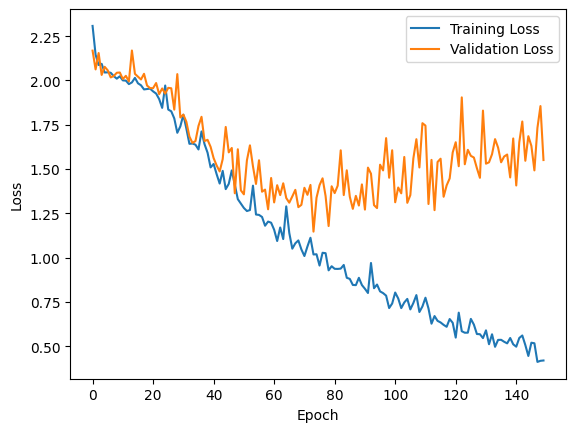

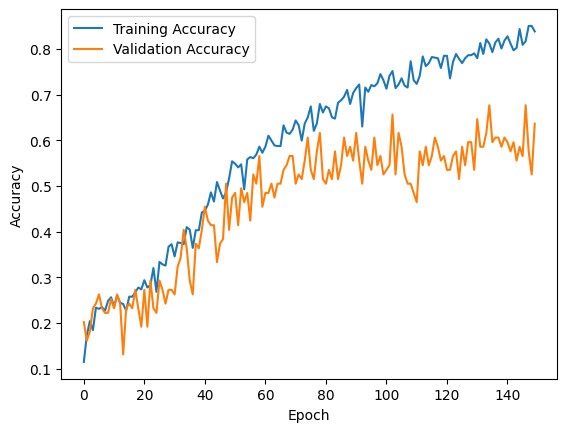

In [10]:


# Choose the model: CNNModel() or TransformerModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedCNNModel()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 150

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,"ImprovedCNNModel.pth")
plot_history(train_loss, train_acc, val_loss, val_acc)


In [8]:
cnn_model = ImprovedCNNModel()  # or OptimizedCNNModel()
cnn_model.load_state_dict(torch.load("ImprovedCNNModel.pth"))


def evaluate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

test_accuracy = evaluate_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5828
